In [146]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score
%matplotlib inline

In [147]:
df = pd.read_csv('UCI_Credit_Card.csv')
df.rename(columns = {'default.payment.next.month':'default'}, inplace=True)

In [148]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


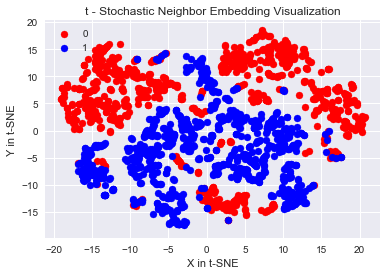

In [124]:
df_tsne = df
df_tsne.drop(df.columns[[0]], axis=1, inplace=True)
negative_examples = df_tsne[df_tsne.default == 0].sample(n = 1000)
positive_examples = df_tsne[df_tsne.default == 1].sample(n = 1000)
tsne_examples = pd.concat([negative_examples, positive_examples], axis = 0)

standard_scaler = StandardScaler()
tsne_standardized = standard_scaler.fit_transform(tsne_examples)

y = tsne_examples.ix[:,-1].values
tsne = TSNE(n_components=2, random_state=0)
x_test_2d = tsne.fit_transform(tsne_standardized)

color_map = {0:'red', 1:'blue'}
plt.figure()
for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x = x_test_2d[y==cl,0], 
                y = x_test_2d[y==cl,1], 
                c = color_map[idx], 
                label = cl)
    
plt.xlabel('X in t-SNE')
plt.ylabel('Y in t-SNE')
plt.legend(loc='upper left')
plt.title('t - Stochastic Neighbor Embedding Visualization')
plt.show()

Converting the categorical features to one-hot encoding, which is best practice since categorical variables do not follow any pattern or order in their values. Education and PAY_0 - PAY_6 are ordinal variables in the dataset, so I kept them in integer values to capture their hierarchical representations

In [149]:
sex = pd.get_dummies(df['SEX'])
sex.columns = ['MALE', 'FEMALE']
marriage = pd.get_dummies(df['MARRIAGE'])
marriage.columns = ['UNKNOWN', 'MARRIED', 'SINGLE', 'OTHER']

In [150]:
label = df['default']

In [151]:
label.value_counts()

0    23364
1     6636
Name: default, dtype: int64

In [152]:
df.drop(df.columns[[0, 2, 4, 24]], axis=1, inplace=True)

In [153]:
df.head()

,LIMIT_BAL,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000.0,2,24,2,2,-1,-1,-2,-2,3913.0,...,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0
1,120000.0,2,26,-1,2,0,0,0,2,2682.0,...,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0
2,90000.0,2,34,0,0,0,0,0,0,29239.0,...,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0
3,50000.0,2,37,0,0,0,0,0,0,46990.0,...,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0
4,50000.0,2,57,-1,0,-1,0,0,0,8617.0,...,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0


In [154]:
df = (df - df.mean()) / df.std()

In [155]:
df['MALE'] = sex['MALE']
df['FEMALE'] = sex['FEMALE']
df['UNKNOWN'] = marriage['UNKNOWN']
df['MARRIED'] = marriage['MARRIED']
df['SINGLE'] = marriage['SINGLE']
df['OTHER'] = marriage['OTHER']

In [156]:
df.head()

,LIMIT_BAL,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,MALE,FEMALE,UNKNOWN,MARRIED,SINGLE,OTHER
0,-1.136701,0.185825,-1.245999,1.794534,1.782318,-0.696652,-0.666588,-1.530021,-1.486016,-0.642490,...,-0.296796,-0.308057,-0.314131,-0.293377,0,1,0,1,0,0
1,-0.365974,0.185825,-1.029030,-0.874977,1.782318,0.138862,0.188743,0.234913,1.992282,-0.659208,...,-0.240001,-0.244226,-0.314131,-0.180875,0,1,0,0,1,0
2,-0.597192,0.185825,-0.161154,0.014860,0.111734,0.138862,0.188743,0.234913,0.253133,-0.298555,...,-0.240001,-0.244226,-0.248679,-0.012122,0,1,0,0,1,0
3,-0.905483,0.185825,0.164300,0.014860,0.111734,0.138862,0.188743,0.234913,0.253133,-0.057490,...,-0.228641,-0.237842,-0.244162,-0.237126,0,1,0,1,0,0
4,-0.905483,0.185825,2.333990,-0.874977,0.111734,-0.696652,0.188743,0.234913,0.253133,-0.578608,...,0.271161,0.266429,-0.269034,-0.255183,1,0,0,1,0,0


In [157]:
df.describe()

,LIMIT_BAL,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,MALE,FEMALE,UNKNOWN,MARRIED,SINGLE,OTHER
count,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,...,3.000000e+04,3.000000e+04,3.000000e+04,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,-4.883501e-17,5.918644e-15,-4.414395e-16,9.095674e-16,2.756374e-15,1.685513e-15,3.053113e-19,-1.099260e-15,-3.924920e-15,-4.653655e-16,...,-2.008184e-15,-1.330972e-16,9.498698e-17,-3.619309e-16,0.396267,0.603733,0.001800,0.455300,0.532133,0.010767
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.489129,0.489129,0.042389,0.498006,0.498975,0.103204
min,-1.213774e+00,-2.344704e+00,-1.571453e+00,-1.764813e+00,-1.558850e+00,-1.532166e+00,-1.521918e+00,-1.530021e+00,-1.486016e+00,-2.944263e+00,...,-2.967963e-01,-3.080574e-01,-3.141309e-01,-2.933772e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-9.054832e-01,-1.079439e+00,-8.120610e-01,-8.749766e-01,-7.235579e-01,-6.966518e-01,-6.665876e-01,-6.475540e-01,-6.164414e-01,-6.473012e-01,...,-2.746460e-01,-2.891632e-01,-2.976042e-01,-2.867536e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-2.118290e-01,1.858252e-01,-1.611538e-01,1.486028e-02,1.117342e-01,1.388625e-01,1.887429e-01,2.349126e-01,2.531332e-01,-3.916819e-01,...,-1.945640e-01,-2.123096e-01,-2.159525e-01,-2.090007e-01,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,5.588978e-01,1.858252e-01,5.982379e-01,1.486028e-02,1.117342e-01,1.388625e-01,1.887429e-01,2.349126e-01,2.531332e-01,2.154883e-01,...,-4.093162e-02,-5.188424e-02,-5.026000e-02,-6.837322e-02,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,6.416421e+00,5.246883e+00,4.720650e+00,7.133555e+00,6.794071e+00,6.822977e+00,7.031387e+00,7.294645e+00,7.209730e+00,1.240276e+01,...,5.059444e+01,3.933152e+01,2.760317e+01,2.944461e+01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [158]:
df['default'] = label

In [140]:
important_features = df.ix[:,0:27].columns

C:\Users\lkjgp\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


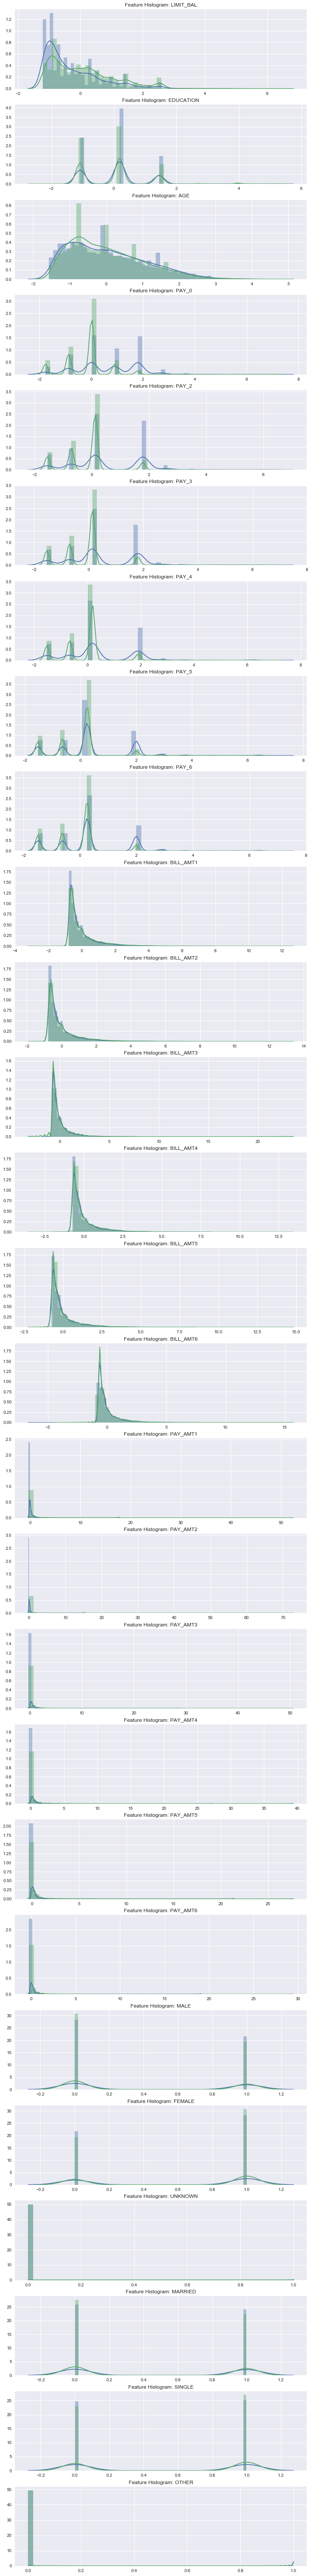

In [143]:
plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(df[important_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.default == 1], bins=50)
    sns.distplot(df[cn][df.default == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('Feature Histogram: ' + str(cn))
plt.show()

In [159]:
df.drop(df.columns[[23,26]], axis=1, inplace=True)

In [161]:
X = df.drop(['default'], 1)
y = df['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [164]:
C = [10, 1, .1, .001]

for c in C:
    clf = LogisticRegression(penalty='l2', C=c)
    clf.fit(X_train, y_train)
    print('C:', c)
    print('Training accuracy:', clf.score(X_train, y_train))
    print('Test accuracy:', clf.score(X_test, y_test))

C: 10
Training accuracy: 0.810746268657
Test accuracy: 0.810101010101
C: 1
Training accuracy: 0.810696517413
Test accuracy: 0.81
C: 0.1
Training accuracy: 0.810696517413
Test accuracy: 0.810808080808
C: 0.001
Training accuracy: 0.805024875622
Test accuracy: 0.804747474747


In [165]:
param_grid = {'n_jobs': [5, 10, 12, 15, 20],
             'n_estimators': [100, 300, 500, 1000]}
model = GridSearchCV(RandomForestClassifier(), param_grid)
model.fit(X_train, y_train)

print('Training accuracy:', model.score(np.array(X_train),np.array(y_train)))
print('Test accuracy:', model.score(np.array(X_test), np.array(y_test)))
print(model.best_params_)

Training accuracy: 0.999502487562
Test accuracy: 0.816868686869
{'n_estimators': 1000, 'n_jobs': 5}


In [168]:
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5], 'learning_rate': [0.01, 0.05, 0.1, 0.5]}
ind_params = {'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1)

In [169]:
optimized_GBM.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5], 'learning_rate': [0.01, 0.05, 0.1, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

[0]	validation_0-error:0.178955	validation_0-logloss:0.671008	validation_1-error:0.182828	validation_1-logloss:0.671181
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 50 rounds.
[1]	validation_0-error:0.177512	validation_0-logloss:0.65123	validation_1-error:0.181818	validation_1-logloss:0.651458
[2]	validation_0-error:0.177413	validation_0-logloss:0.633362	validation_1-error:0.17798	validation_1-logloss:0.633658
[3]	validation_0-error:0.177363	validation_0-logloss:0.618049	validation_1-error:0.178889	validation_1-logloss:0.618559
[4]	validation_0-error:0.177711	validation_0-logloss:0.602811	validation_1-error:0.178687	validation_1-logloss:0.603451
[5]	validation_0-error:0.179254	validation_0-logloss:0.590152	validation_1-error:0.180909	validation_1-logloss:0.590872
[6]	validation_0-error:0.177562	validation_0-logloss:0.577178	validation_1-error:0.178889	validation_1-logloss:0.5778

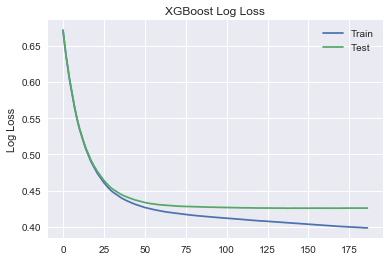

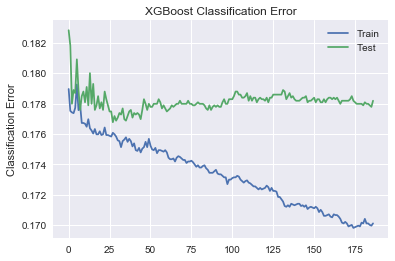

In [162]:
model = xgboost.XGBClassifier(learning_rate =0.05,
 n_estimators=3000,
 max_depth=4,
 min_child_weight=1,
 gamma=0.1,
 subsample=0.5,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=8,
 scale_pos_weight=1,
 seed=22)
evaluation_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=evaluation_set, early_stopping_rounds=50, verbose=True)

y_predictions = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, y_predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()